## Mask R-CNN - Train on NewShapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')

import mrcnn.model_mrcnn  as mrcnn_modellib
import mrcnn.model_fcn    as fcn_modellib
import mrcnn.visualize    as visualize
import mrcnn.newshapes    as shapes
import mrcnn.utils        as utils

from datetime           import datetime   
from mrcnn.utils        import command_line_parser, Paths
from mrcnn.config       import Config
from mrcnn.dataset      import Dataset 
from mrcnn.datagen      import data_generator, load_image_gt, data_gen_simulate
# from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
# from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
# from mrcnn.coco         import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
from mrcnn.prep_notebook import mrcnn_newshape_train
from mrcnn.newshapes    import prep_newshape_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = " --epochs 2 "
input_parms +=" --steps_in_epoch 32 "
input_parms +=" --last_epoch 0 " 
input_parms +=" --batch_size 1 " 
input_parms +=" --lr 0.00001 "
input_parms +=" --val_steps 8 " 
input_parms +=" --mrcnn_logs_dir train_mrcnn_newshapes "
input_parms +=" --fcn_logs_dir   train_fcn8_newshapes "
input_parms +=" --mrcnn_model    last "
input_parms +=" --fcn_model      init "
input_parms +=" --opt            adagrad "
input_parms +=" --fcn_arch       fcn8 " 
input_parms +=" --fcn_layers     all " 
input_parms +=" --sysout        screen "
input_parms +=" --new_log_folder    "
# input_parms +="--fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
 

args = parser.parse_args(input_parms.split())
# args = parser.parse_args()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

--> Execution started at: 12-16-2018 @ 16:30:21
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 


###  Build Model

In [11]:
from mrcnn.prep_notebook import mrcnn_newshape_train
mrcnn_model= mrcnn_newshape_train(args = args)


Arguments passed :
--------------------
batch_size                     1
coco_classes                   None
epochs                         2
fcn_arch                       FCN8
fcn_layers                     ['all']
fcn_logs_dir                   train_fcn8_newshapes
fcn_losses                     fcn_BCE_loss
fcn_model                      init
last_epoch                     0
lr                             0.00001
mrcnn_exclude_layers           None
mrcnn_logs_dir                 train_mrcnn_newshapes
mrcnn_model                    last
new_log_folder                 True
opt                            ADAGRAD
scale_factor                   4
steps_in_epoch                 32
sysout                         SCREEN
val_steps                      8


>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
COCO_MODEL_PATH                F:\PretrainedMode

    prob_grid_clipped      :  (?, 32, 32)
    old_style_scores       :  (1, 7, 32, 3)  Keras tensor  False
    alt_scores_1    :  (None, 3)  Keras tensor  False
    alt_scores_1(by class)       :  (1, 7, 32, 3)  Keras tensor  False

       Normalize_scores() ------------------------------------------------------
         input shape      :  (1, 7, 32, 3)
         reduce_min shape :  (1, 7, 1, 3)
         reduce_max shape :  (1, 7, 1, 3)
             output shape :  (1, 7, 32, 3)

    alt_scores_1_norm(by_class)  :  (1, 7, 32, 3) (1, 7, 32, 3)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 32, 32)
    gauss_heatmap   :  (1, 7, 32, 32, 32)

    Reduce MAX based on class ---------------------------------------------
    gaussian_heatmap :  (1, 7, 32, 32) Keras tensor  False
    hm_indices shape         : (?, 2) (None, 2)
    pt2_heatmaps             : (?, 32, 32) (None, 32, 32)
    alt_scores_2    :  (N

###  Print some model information 

In [ ]:
mrcnn_model.layer_info()

### Load saved weights

In [47]:
##------------------------------------------------------------------------------------
## Load Mask RCNN Model Weight file
##------------------------------------------------------------------------------------
# exclude_list = ["mrcnn_class_logits"]
exclude_list = ["mrcnn_class_logits", "mrcnn_bbox_fc"]   ## <-- must be excluded when wanting to init from mask_rcnn_shapes.h5
mrcnn_model.load_model_weights(init_with = 'last', exclude = exclude_list, verbose = 1)   

-----------------------------------------------
 Load Model with init parm: [ last ]
 Exclude layers: 
    -  mrcnn_class_logits
    -  mrcnn_bbox_fc
-----------------------------------------------
 ---> last
>>> load_weights() from : F:\models\train_mrcnn_newshapes\mrcnn20181216T1631\mrcnn_0002.h5
    Weights file loaded: F:\models\train_mrcnn_newshapes\mrcnn20181216T1631\mrcnn_0002.h5 
MRCNN  MODEL Load weight file COMPLETE 


### Build newshape datasets

In [30]:
# del dataset_train, dataset_val, train_generator, val_generator
# from mrcnn.prep_notebook import prep_newshape_dataset
dataset_train, train_generator = prep_newshape_dataset( mrcnn_model.config, 10000, generator=True)
dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_model.config,  2500, generator=True)
class_names = dataset_train.class_names

Prepares complete
Prepares complete


In [31]:
print(type(dataset_train), type(train_generator))
print(type(dataset_val), type(val_generator))
print(len(dataset_train.image_info))
print(len(dataset_val.image_info))
print(len(dataset_train.image_ids), len(dataset_val.image_info))
# dataset_train.display_active_class_info()
print(dataset_train.class_from_source_map)
print(dataset_train.class_info)

<class 'mrcnn.newshapes.NewShapesDataset'> <class 'generator'>
10000
<class 'mrcnn.newshapes.NewShapesDataset'> <class 'generator'>
2500
10000 2500
{'.0': 0, 'shapes.2': 2, 'shapes.3': 3, 'shapes.5': 5, 'shapes.1': 1, 'shapes.4': 4, 'shapes.6': 6}
[{'id': 0, 'source': '', 'category': 'background', 'img_count': 0, 'internal_id': 0, 'name': 'BG'}, {'id': 1, 'source': 'shapes', 'category': None, 'img_count': 0, 'internal_id': 1, 'name': 'person'}, {'id': 2, 'source': 'shapes', 'category': None, 'img_count': 0, 'internal_id': 2, 'name': 'car'}, {'id': 3, 'source': 'shapes', 'category': None, 'img_count': 0, 'internal_id': 3, 'name': 'sun'}, {'id': 4, 'source': 'shapes', 'category': None, 'img_count': 0, 'internal_id': 4, 'name': 'building'}, {'id': 5, 'source': 'shapes', 'category': None, 'img_count': 0, 'internal_id': 5, 'name': 'tree'}, {'id': 6, 'source': 'shapes', 'category': None, 'img_count': 0, 'internal_id': 6, 'name': 'cloud'}]


### Load Training Files and Display Images

####  Display next image from generator

In [28]:
train_batch_x, train_batch_y = next(train_generator)

 Image_id    :  914  Reference:  [('cloud', (131, 67, 251), (15, 29, 33, 8)), ('cloud', (105, 53, 65), (94, 32, 40, 13))] Coco Id: 914
 Image meta  :  [914 128 128   3   0   0 128 128]
 Class ids   :  (2,)    [6 6]
 Class Names :  ['cloud', 'cloud']


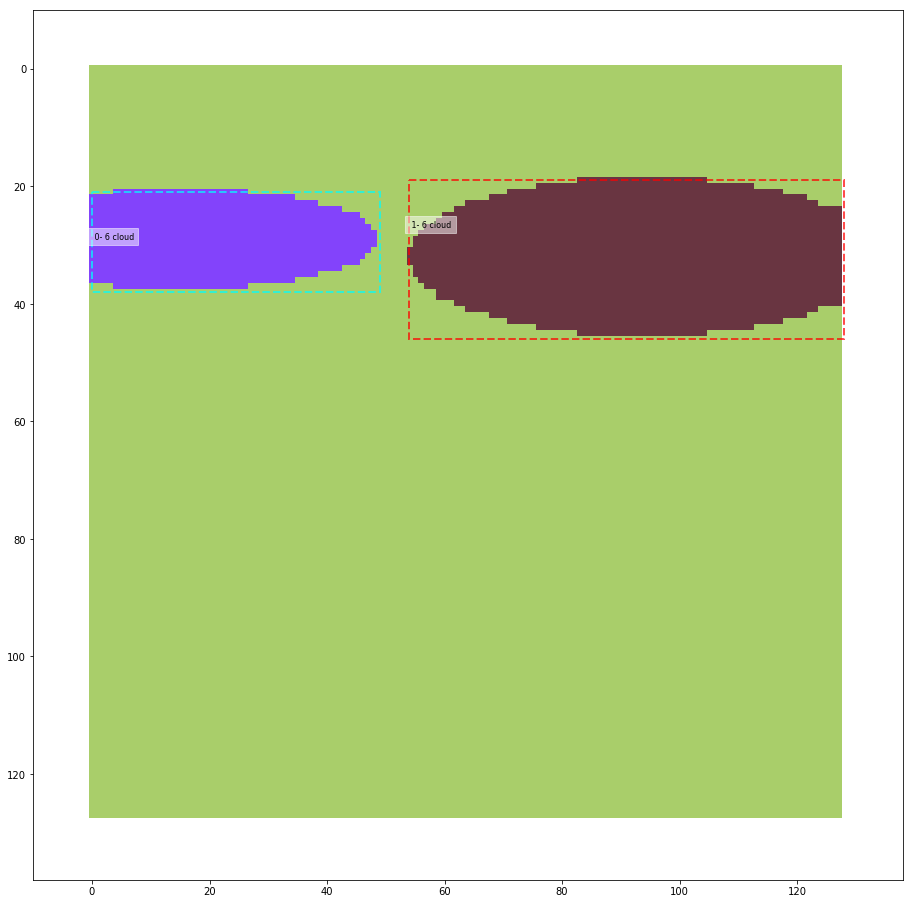

In [32]:
visualize.display_training_batch(dataset_train, train_batch_x)

class_names = dataset_train.class_names
# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
# img_meta    = train_batch_x[imgmeta_idx]

# for img_idx in range(mrcnn_config.BATCH_SIZE):
#     image_id = img_meta[img_idx,0]
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     bbox = utils.extract_bboxes(mask)
#     print('Image id: ',image_id)
#     print('Image meta', img_meta[img_idx])
# #     print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
#     visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))  

#### Load a specific image using image_id

In [ ]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 89243: Person, bicylce and traiffic lights
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 101623 (cake and forks), 41423 (elephant & people)
## 33477 Table, bowl, cup, sandwich, knife
# train_batch_x, train_batch_y = next(train_generator)
# IMAGE_LIST = [75040] 
# IMAGE_LIST = [89243]
IMAGE_LIST = [2000,4000,5000,6000]
# IMAGE_LIST = [29731]
train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_model.config, IMAGE_LIST)

visualize.display_training_batch(dataset_train, train_batch_x)


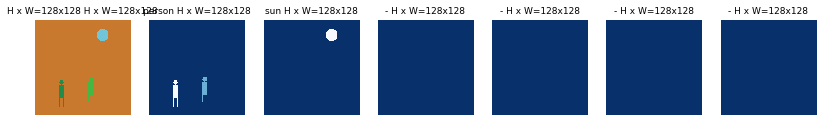

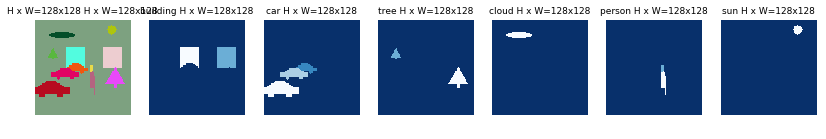

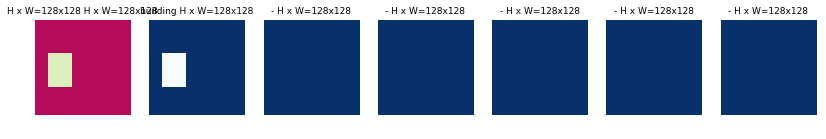

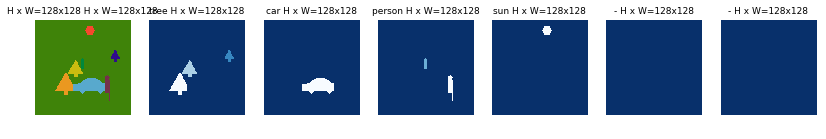

In [45]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=6)

### Train mrcnn model : `train()`

In [ ]:
# mrcnn_model.config.EPOCHS_TO_RUN = 1
# mrcnn_model.config.STEPS_PER_EPOCH = 2
# mrcnn_model.config.SYSOUT = 'screen'
 
print('    last epoch ran : ',mrcnn_model.config.LAST_EPOCH_RAN)
print('    epochs to run  : ',mrcnn_model.config.EPOCHS_TO_RUN)
print('    steps per epoch: ',mrcnn_model.config.STEPS_PER_EPOCH)
print('    learning rate  : ', mrcnn_model.config.LEARNING_RATE)
print('    momentum       : ', mrcnn_model.config.LEARNING_MOMENTUM)
print('    weight decay   : ',mrcnn_model.config.WEIGHT_DECAY)


## Training mrcnn, fpn, rpn layers


Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

- Or now we can pass a list of layers we want to train in layers !
2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# Wed 09-05-2018
# config.STEPS_PER_EPOCH        = 8
# config.EARLY_STOP_PATIENCE    = 70
train_layers = [ 'mrcnn', 'fpn','rpn']   ## equivalent to "heads"
loss_names   = [ "rpn_class_loss", "rpn_bbox_loss" , "mrcnn_class_loss", "mrcnn_bbox_loss"]
# train_layers = [ 'mrcnn']
# loss_names   = [ "mrcnn_class_loss", "mrcnn_bbox_loss"]

mrcnn_model.config.LAST_EPOCH_RAN = 2
mrcnn_model.config.EPOCHS_TO_RUN  = 20
mrcnn_model.config.LEARNING_RATE   = 0.001
# mrcnn_model.config.STEPS_PER_EPOCH = config.STEPS_PER_EPOCH

mrcnn_model.epoch = mrcnn_model.config.LAST_EPOCH_RAN
mrcnn_model.train(dataset_train, 
            dataset_val, 
            learning_rate = mrcnn_model.config.LEARNING_RATE, 
            epochs_to_run = mrcnn_model.config.EPOCHS_TO_RUN,
            layers = train_layers,
            losses = loss_names)                  
#             epochs = 25,            # total number of epochs to run (accross multiple trainings)
#             batch_size = 0
#             steps_per_epoch = 0 


['mrcnn', 'fpn', 'rpn']
['(mrcnn\\_.*)', '(fpn\\_.*)', '(rpn\\_.*)']
layers regex : (mrcnn\_.*)|(fpn\_.*)|(rpn\_.*)
type train_dataset: <class 'mrcnn.newshapes.NewShapesDataset'>
type val_dataset: <class 'mrcnn.newshapes.NewShapesDataset'>
    learning rate :  0.001
    momentum      :  0.9


Selecting layers to train
-------------------------
Layer    Layer Name               Layer Type
   0  input_image            (InputLayer          )   ............................no weights to train ]
   1  zero_padding2d_1       (ZeroPadding2D       )   ............................no weights to train ]
   2  conv1                  (Conv2D              )   ............................not a layer we want to train ]
   3  bn_conv1               (BatchNorm           )   ............................not a layer we want to train ]
   4  activation_1           (Activation          )   ............................no weights to train ]
   5  max_pooling2d_1        (MaxPooling2D        )   .................

 333  res5b_out              (Activation          )   ............................no weights to train ]
 334  res5c_branch2a         (Conv2D              )   ............................not a layer we want to train ]
 335  bn5c_branch2a          (BatchNorm           )   ............................not a layer we want to train ]
 336  activation_66          (Activation          )   ............................no weights to train ]
 337  res5c_branch2b         (Conv2D              )   ............................not a layer we want to train ]
 338  bn5c_branch2b          (BatchNorm           )   ............................not a layer we want to train ]
 339  activation_67          (Activation          )   ............................no weights to train ]
 340  res5c_branch2c         (Conv2D              )   ............................not a layer we want to train ]
 341  bn5c_branch2c          (BatchNorm           )   ............................not a layer we want to train ]
 342  add_

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 3/22
32/32 [==============================] - 169s 5s/step - loss: 25.7922 - rpn_class_loss: 0.3293 - rpn_bbox_loss: 2.4993 - mrcnn_class_loss: 11.2732 - mrcnn_bbox_loss: 11.6904 - val_loss: 2.6448 - val_rpn_class_loss: 0.1454 - val_rpn_bbox_loss: 1.0258 - val_mrcnn_class_loss: 0.9672 - val_mrcnn_bbox_loss: 0.5064

Epoch 00003: val_loss improved from inf to 2.64483, saving model to F:\models\train_mrcnn_newshapes\mrcnn20181216T1631\mrcnn_0003.h5
Epoch 4/22
32/32 [==============================] - 154s 5s/step - loss: 2.3262 - rpn_class_loss: 0.0962 - rpn_bbox_loss: 0.9055 - mrcnn_class_loss: 0.6943 - mrcnn_bbox_loss: 0.6303 - val_loss: 2.7235 - val_rpn_class_loss: 0.1066 - val_rpn_bbox_loss: 0.7313 - val_mrcnn_class_loss: 0.9525 - val_mrcnn_bbox_loss: 0.9331

Epoch 00004: val_loss did not improve from 2.64483
Epoch 5/22
32/32 [==============================] - 148s 5s/step - loss: 1.9916 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 0.7675 - mrcnn_class_loss: 0.5365 - mrcnn_bbox_loss

## Fine Tuning
Fine tune all layers

    - #### Or now we can pass a list of layers we want to train in layers !
2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

### Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_2500.h5")
model.keras_model.save_weights(model_path)

## Push Data thru model using get_layer_output()

## Plot Heatmaps `pr_heatmap` and `gt_heatmap`

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
img = 0
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox[0:3,:])
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox[0:3])

# image_id = img_meta[img,0]
# print('Image id: ',image_id)
# p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
#             load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# # print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
# print(p_gt_bbox)
# print(p_gt_class_id)
# visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display Predicted  Ground Truth Bounding Boxes  `gt_tensor` and `gt_tensor2`

layers_out[22]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes
layers_out[28]  `gt_tensor2` is based on input_gt_class_ids and input_normlzd_gt_boxes, generated using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 0
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[22][img])
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[0:2,2:6])


## Display RoI proposals `pred_bboxes` generated for one class

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle 3

In [ ]:
img = 0
cls = 1 # <==== Class to display
pred_tensor = layers_out[19]   # numpy pred_tesnor
# pred_tensor = layers_out[25]   # tensorflow pred_tensor 

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
print(p_image_meta)dd
print(pred_tensor[img,cls,:].shape)
print(pred_tensor[img,cls])
#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_tensor[img,cls,:].tolist() ]
print(caps)

visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

In [ ]:
layers_out[0][0] * [128, 128,128,128]   #output_rois*

### Calculate  mrcnn_bbox_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
target_bbox      = layers_out[2][0:1]
mrcnn_bbox       = layers_out[10][0:1]
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print('target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class with max probability', mrcnn_class_ids.shape)
print(mrcnn_class_ids)
print('target_bboxes', target_bbox.shape)
# print(target_bbox)  # tgt_bounding boxes
print('mrcnn_bboxes',mrcnn_bbox.shape)
# print(mrcnn_bbox)  #mrcnn_bboxes
pred_bbox = mrcnn_bbox

# calc mrcnn_bbox_loss
target_class_ids = K.reshape(target_class_ids, (-1,))
print(target_class_ids.shape)
target_bbox      = K.reshape(target_bbox, (-1, 4))
print('target_bboxx: ', target_bbox.shape)
pred_bbox        = K.reshape(pred_bbox, (-1, pred_bbox.shape[2], 4))
print('pred_bbox : ', pred_bbox.shape)

positive_roi_ix        = tf.where(target_class_ids > 0)[:, 0]
print(positive_roi_ix.eval())
positive_roi_class_ids = tf.cast( tf.gather(target_class_ids, positive_roi_ix), tf.int64)
print(positive_roi_class_ids.eval())
indices                = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)
print(indices.eval())


target_bbox = tf.gather(target_bbox, positive_roi_ix)
print(target_bbox.eval())
pred_bbox   = tf.gather_nd(pred_bbox, indices)
print(pred_bbox.eval())

print('tf.size ',tf.size(target_bbox).eval())

diff = K.abs(target_bbox - pred_bbox)
print(diff.eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(less_than_one.eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print( (1-less_than_one).eval())



# loss        = K.switch(tf.size(target_bbox) > 0,
#                 smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
#                 tf.constant(0.0))
print(loss.eval())
sumloss = K.sum(loss)
print(sumloss.eval())
print((sumloss/40).eval())
meanloss        = K.mean(loss)
print(meanloss.eval())

###  Calculate mrcnn_class_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
pred_class_logits = layers_out[8][0:1]
active_class_ids    = np.array([1,1,1,1])

# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print(' target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class logits', pred_class_logits.shape)
print(pred_class_logits)
print(' active, class_ids ', active_class_ids.shape)
print(active_class_ids)  # tgt_bounding boxes

pred_class_ids = tf.argmax(pred_class_logits, axis=2)
print(pred_class_ids.eval())  #mrcnn_bboxes
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print(mrcnn_class_ids)
# pred_bbox = mrcnn_bbox
pred_active = tf.to_float(tf.gather(active_class_ids, pred_class_ids))
print(pred_active.eval())
# calc mrcnn_bbox_loss
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
       labels=target_class_ids, logits=pred_class_logits)
print(loss.eval())

loss = loss * tf.to_float(pred_active)
print(loss.eval())

print(tf.reduce_sum(loss).eval())
print(tf.reduce_sum(pred_active).eval())
loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
print(loss.eval())

###  Calculate mrcnn_mask_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids    = layers_out[1][0:3]
target_masks        = layers_out[3][0:3]
pred_masks          = layers_out[11][0:3]
# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print('    target_class_ids shape :', target_class_ids.shape)
print('    target_masks     shape :', target_masks.shape)
print('    pred_masks       shape :', pred_masks.shape)    


target_class_ids = K.reshape(target_class_ids, (-1,))
print('    target_class_ids shape :', target_class_ids.shape, '\n', target_class_ids.eval())

mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', mask_shape.shape, mask_shape.eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', pred_shape.shape, pred_shape.eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        


pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        

# Only positive ROIs contribute to the loss. And only
# the class specific mask of each ROI.
positive_ix        = tf.where(target_class_ids > 0)[:, 0]
positive_class_ids = tf.cast(tf.gather(target_class_ids, positive_ix), tf.int64)
indices            = tf.stack([positive_ix, positive_class_ids], axis=1)
print(indices.eval())



y_true = tf.gather(target_masks, positive_ix)
print('     y_true shape:', tf.shape(y_true).eval())
y_pred = tf.gather_nd(pred_masks, indices)
print('     y_pred shape:', tf.shape(y_pred).eval())

loss = K.switch(tf.size(y_true) > 0,
                K.binary_crossentropy(target=y_true, output=y_pred),
                tf.constant(0.0))
print(tf.shape(loss).eval())

loss = K.mean(loss)
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())

### Calculate a pixel loss on fcn_gaussian and gt_gaussian 

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss
pred_masks          = layers_out[12][0:3]
target_masks        = layers_out[27][0:3]

print('    target_masks     shape :', tf.shape(target_masks).eval())
print('    pred_masks       shape :', tf.shape(pred_masks).eval())    

diff = K.abs(target_masks - pred_masks)
print(tf.shape(diff).eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
print(tf.shape(less_than_one).eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
print(tf.shape(loss).eval())

# print( (1-less_than_one).eval())

# loss = K.switch(tf.size(y_true) > 0,
#                 K.binary_crossentropy(target=y_true, output=y_pred),
#                 tf.constant(0.0))
meanloss = K.mean(loss)
print(tf.shape(meanloss).eval())
print(meanloss.eval())
# loss = K.reshape(loss, [1, 1])
# print('     final loss shape:', loss.get_shape())
# return loss


mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', tf.shape(mask_shape).eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[1], mask_shape[2]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', tf.shape(pred_shape).eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[1], pred_shape[2]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())
# Permute predicted masks to [N, num_classes, height, width]
# diff = K.abs(target_masks - pred_masks)
# print(tf.shape(diff).eval())

# less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(tf.shape(less_than_one).eval())

# loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print(tf.shape(loss).eval())

# meanloss = K.mean(loss)
# print(tf.shape(meanloss).eval())
# print(meanloss.eval())

loss = K.switch(tf.size(target_masks) > 0,
                smooth_l1_loss(y_true=target_masks, y_pred=pred_masks),
                tf.constant(0.0))
loss = K.mean(loss)
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', loss.get_shape())
print(loss.eval())

###  Mean values of GT, Pred, and FCN heatmaps 

In [ ]:
pred_masks = tf.identity(layers_out[24])
gt_masks = tf.identity(layers_out[27])
fcn_masks = tf.identity(layers_out[12])
print(gt_masks.shape, fcn_masks.shape)
for img in range(5):
    for cls in range(4):
        gt_mean = K.mean(gt_masks[img,:,:,cls])
        fcn_mean= K.mean(fcn_masks[img,:,:,cls])
        pred_mean= K.mean(pred_masks[img,:,:,cls])
        print('Img/Cls: ', img, '/', cls,'    gtmean: ', gt_mean.eval(), '\t fcn : ' , fcn_mean.eval(), '\t pred :', pred_mean.eval())

In [ ]:
img  = 0
class_probs = layers_out[9][img]   # mrcnn_class
deltas      = layers_out[10][img]       # mrcnn_bbox

print(class_probs.shape)
print('class probabilities')
print(class_probs)
class_ids = np.argmax(layers_out[9][img],axis = 1)     # mrcnn_class_ids
print(' class with max probability')
print(class_ids)


# layers_out[10][2,0,3]
print('deltas.shape :', deltas.shape)
print(deltas[0:4])

deltas_specific = deltas[np.arange(32),class_ids]
print('deltas of max prob class: ', deltas_specific.shape)
print(deltas_specific[0:5])
output_rois = layers_out[0][img]*[128,128,128,128]
print('output_rois: ', output_rois.shape)
print(output_rois[0:])

refined_rois    = apply_box_deltas(output_rois, deltas_specific * config.BBOX_STD_DEV)
print('refined rois: ',refined_rois.shape)
print(refined_rois)